# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## Object detection imports
Here are the imports from the object detection module.

In [3]:
import label_map_util
import utils
import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
#MODEL_NAME = 'faster_rcnn_nas_lowproposals_coco_2017_11_08'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'mscoco_label_map.pbtxt'

NUM_CLASSES = 90

## Download Model

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

KeyboardInterrupt: 

## Load a (frozen) Tensorflow model into memory.

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [6]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [7]:
print(categories)

[{'id': 1, 'name': u'person'}, {'id': 2, 'name': u'bicycle'}, {'id': 3, 'name': u'car'}, {'id': 4, 'name': u'motorcycle'}, {'id': 5, 'name': u'airplane'}, {'id': 6, 'name': u'bus'}, {'id': 7, 'name': u'train'}, {'id': 8, 'name': u'truck'}, {'id': 9, 'name': u'boat'}, {'id': 10, 'name': u'traffic light'}, {'id': 11, 'name': u'fire hydrant'}, {'id': 13, 'name': u'stop sign'}, {'id': 14, 'name': u'parking meter'}, {'id': 15, 'name': u'bench'}, {'id': 16, 'name': u'bird'}, {'id': 17, 'name': u'cat'}, {'id': 18, 'name': u'dog'}, {'id': 19, 'name': u'horse'}, {'id': 20, 'name': u'sheep'}, {'id': 21, 'name': u'cow'}, {'id': 22, 'name': u'elephant'}, {'id': 23, 'name': u'bear'}, {'id': 24, 'name': u'zebra'}, {'id': 25, 'name': u'giraffe'}, {'id': 27, 'name': u'backpack'}, {'id': 28, 'name': u'umbrella'}, {'id': 31, 'name': u'handbag'}, {'id': 32, 'name': u'tie'}, {'id': 33, 'name': u'suitcase'}, {'id': 34, 'name': u'frisbee'}, {'id': 35, 'name': u'skis'}, {'id': 36, 'name': u'snowboard'}, {'id

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
import cv2
IMAGE_SIZE = (12, 8)

In [10]:
PATH_TO_TEST_IMAGES_DIR = '/Users/nikhilkasukurthi/Desktop'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

In [11]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      utils.get_class(image, classes, category_index, boxes, scores)
#       print(boxes)
      # Visualization of the results of a detection.
#       print(classes)
#       vis_util.visualize_boxes_and_labels_on_image_array(
#           image_np,
#           np.squeeze(boxes),
#           np.squeeze(classes).astype(np.int32),
#           np.squeeze(scores),
#           category_index,
#           use_normalized_coordinates=True,
#           line_thickness=8)
#       plt.figure(figsize=IMAGE_SIZE)
#       plt.imshow(image_np)

NameError: global name 'scores' is not defined

Function called
person
[[[ 32  22  10]
  [ 32  22  10]
  [ 32  22  10]
  ..., 
  [ 42  35  17]
  [ 42  35  15]
  [ 42  35  15]]

 [[ 32  22  10]
  [ 32  22  10]
  [ 32  22  10]
  ..., 
  [ 39  32  14]
  [ 38  31  11]
  [ 38  31  11]]

 [[ 32  22  10]
  [ 32  22  10]
  [ 32  22  10]
  ..., 
  [ 36  30   7]
  [ 29  22   2]
  [ 28  21   1]]

 ..., 
 [[149  90  13]
  [153  94  17]
  [160 101  24]
  ..., 
  [174 113  25]
  [174 113  25]
  [174 113  25]]

 [[153  94  17]
  [160 101  24]
  [177 118  41]
  ..., 
  [173 112  24]
  [173 112  24]
  [173 112  24]]

 [[167 108  31]
  [171 112  35]
  [178 119  42]
  ..., 
  [173 112  24]
  [173 112  24]
  [173 112  24]]]
Function called
person
[[[ 32  22  10]
  [ 32  22  10]
  [ 32  22  10]
  ..., 
  [ 42  35  17]
  [ 42  35  15]
  [ 42  35  15]]

 [[ 32  22  10]
  [ 32  22  10]
  [ 32  22  10]
  ..., 
  [ 39  32  14]
  [ 38  31  11]
  [ 38  31  11]]

 [[ 32  22  10]
  [ 32  22  10]
  [ 32  22  10]
  ..., 
  [ 36  30   7]
  [ 29  22   2]
  [ 28  21 

Function called
person
[[[ 34  23   8]
  [ 34  23   8]
  [ 34  23   8]
  ..., 
  [ 33  28  14]
  [ 35  27  14]
  [ 33  25  12]]

 [[ 34  23   8]
  [ 34  23   8]
  [ 34  23   8]
  ..., 
  [ 33  28  14]
  [ 35  27  14]
  [ 33  25  12]]

 [[ 34  23   8]
  [ 34  23   8]
  [ 34  23   8]
  ..., 
  [ 33  28  14]
  [ 35  27  14]
  [ 33  25  12]]

 ..., 
 [[162 101  22]
  [162 101  22]
  [162 101  22]
  ..., 
  [161  99  20]
  [161  98  22]
  [160  97  21]]

 [[159  98  19]
  [159  98  19]
  [160  99  20]
  ..., 
  [155  93  14]
  [155  93  14]
  [153  91  12]]

 [[158  97  18]
  [158  97  18]
  [158  97  18]
  ..., 
  [157  95  16]
  [156  94  15]
  [153  91  12]]]
Function called
person
[[[ 34  23   8]
  [ 34  23   8]
  [ 34  23   8]
  ..., 
  [ 34  29  15]
  [ 38  30  17]
  [ 39  31  18]]

 [[ 34  23   8]
  [ 34  23   8]
  [ 34  23   8]
  ..., 
  [ 34  29  15]
  [ 37  29  16]
  [ 38  30  17]]

 [[ 34  23   8]
  [ 34  23   8]
  [ 34  23   8]
  ..., 
  [ 33  28  14]
  [ 36  28  15]
  [ 35  27 

/Users/nikhilkasukurthi/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Function called
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 32  22  10]
  [ 31  21   9]
  [ 31  21   9]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 34  24  12]
  [ 34  24  12]
  [ 33  23  11]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 38  28  16]
  [ 38  28  16]
  [ 37  27  15]]

 ..., 
 [[163 102  23]
  [163 102  23]
  [163 102  23]
  ..., 
  [153  90  14]
  [150  87  13]
  [148  85  11]]

 [[160  99  20]
  [160  99  20]
  [161 100  21]
  ..., 
  [154  91  17]
  [150  87  13]
  [148  85  11]]

 [[158  97  18]
  [159  98  19]
  [159  98  19]
  ..., 
  [149  86  12]
  [147  84  10]
  [146  83   9]]]
Function called
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 32  23   8]
  [ 31  21  11]
  [ 31  21  11]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 34  25  10]
  [ 34  24  14]
  [ 33  23  13]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 38  29  14]
  [ 38  28  18]
  [ 37  27 

Function called
person
[[[ 30  20   8]
  [ 30  20   8]
  [ 30  20   8]
  ..., 
  [ 31  26  12]
  [ 33  25  12]
  [ 33  25  12]]

 [[ 30  20   8]
  [ 30  20   8]
  [ 30  20   8]
  ..., 
  [ 31  26  12]
  [ 33  25  12]
  [ 33  25  12]]

 [[ 30  20   8]
  [ 30  20   8]
  [ 30  20   8]
  ..., 
  [ 31  26  12]
  [ 33  28  14]
  [ 33  28  14]]

 ..., 
 [[161 100  19]
  [161 100  19]
  [161 100  19]
  ..., 
  [129  72  12]
  [151  91  23]
  [157  97  29]]

 [[160  99  18]
  [160  99  18]
  [160  99  18]
  ..., 
  [129  72  14]
  [151  90  25]
  [157  96  31]]

 [[160  99  18]
  [160  99  18]
  [160  99  18]
  ..., 
  [128  71  13]
  [151  90  25]
  [156  95  30]]]
Function called
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 30  25  13]
  [ 33  25  14]
  [ 33  25  14]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 31  26  14]
  [ 33  25  14]
  [ 33  25  14]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 33  28  16]
  [ 33  25  14]
  [ 35  27 

Function called
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 29  21   8]
  [ 28  20   7]
  [ 28  20   7]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 30  22   9]
  [ 29  21   8]
  [ 29  21   8]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 31  23  10]
  [ 32  24  11]
  [ 32  24  11]]

 ..., 
 [[162  99  23]
  [163 100  24]
  [162 100  24]
  ..., 
  [173 112  28]
  [174 113  29]
  [174 113  29]]

 [[162  99  23]
  [163 100  24]
  [162 100  24]
  ..., 
  [171 109  28]
  [171 109  30]
  [174 112  33]]

 [[162  99  23]
  [163 100  24]
  [162 100  24]
  ..., 
  [169 107  26]
  [169 107  28]
  [171 109  30]]]
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 29  21   8]
  [ 28  20   7]
  [ 28  20   7]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 30  22   9]
  [ 29  21   8]
  [ 29  21   8]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 31  23  10]
  [ 32  24  11]
  [ 32  24  11]]

 ..., 
 [

Function called
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 33  21   9]
  ..., 
  [ 52  39  16]
  [ 55  42  19]
  [ 50  37  14]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 33  21   9]
  ..., 
  [ 56  43  20]
  [ 52  39  16]
  [ 51  38  15]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 33  21   9]
  ..., 
  [ 44  31  10]
  [ 43  30   9]
  [ 42  29   8]]

 ..., 
 [[159  96  20]
  [159  96  20]
  [157  94  18]
  ..., 
  [176 113  21]
  [192 130  33]
  [194 132  35]]

 [[154  91  15]
  [154  91  15]
  [153  90  14]
  ..., 
  [175 112  20]
  [183 121  24]
  [187 125  28]]

 [[154  91  15]
  [154  91  15]
  [154  91  15]
  ..., 
  [175 112  20]
  [178 116  19]
  [184 122  25]]]
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 33  21   9]
  ..., 
  [ 52  39  16]
  [ 55  42  19]
  [ 50  37  14]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 33  21   9]
  ..., 
  [ 56  43  20]
  [ 52  39  16]
  [ 51  38  15]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 33  21   9]
  ..., 
  [ 44  31  10]
  [ 43  30   9]
  [ 42  29   8]]

 ..., 
 [

Function called
Function called
Function called
Function called
Function called
Function called
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 41  26   4]
  [ 40  27   6]
  [ 40  27   6]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 42  27   5]
  [ 41  28   7]
  [ 41  28   7]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 42  27   5]
  [ 41  28   7]
  [ 41  28   7]]

 ..., 
 [[166 101  21]
  [166 101  21]
  [166 101  21]
  ..., 
  [118  58   6]
  [117  54   3]
  [116  53   2]]

 [[166 101  21]
  [166 101  21]
  [166 101  21]
  ..., 
  [123  63  11]
  [122  59   8]
  [121  58   7]]

 [[166 101  21]
  [166 101  21]
  [166 101  21]
  ..., 
  [126  66  14]
  [124  61  10]
  [123  60   9]]]
Function called
person
[[[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 43  28   6]
  [ 41  28   7]
  [ 41  28   7]]

 [[ 32  20   8]
  [ 32  20   8]
  [ 32  20   8]
  ..., 
  [ 43  28   6]
  [ 41  28   7]
  [ 41  28   7]]

 [[ 32  20   8]
  [

Function called
person
[[[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 54  36  15]
  [ 52  33   8]
  [ 49  30   5]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 54  36  15]
  [ 53  34   9]
  [ 49  30   5]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 53  35  14]
  [ 52  33   8]
  [ 51  32   7]]

 ..., 
 [[171 107  24]
  [171 107  24]
  [171 107  24]
  ..., 
  [145  82  15]
  [144  84  16]
  [152  92  24]]

 [[170 106  23]
  [170 106  23]
  [170 106  23]
  ..., 
  [145  82  15]
  [143  83  15]
  [150  90  22]]

 [[170 106  23]
  [170 106  23]
  [170 106  23]
  ..., 
  [145  82  15]
  [142  82  14]
  [146  86  18]]]
Function called
person
[[[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 57  40  16]
  [ 54  35  10]
  [ 51  32   7]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 55  38  14]
  [ 53  34   9]
  [ 51  32   7]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 54  37  13]
  [ 53  34   9]
  [ 52  33 

Function called
person
[[[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 57  43  16]
  [ 54  37  13]
  [ 50  33   9]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 53  39  12]
  [ 53  36  12]
  [ 50  33   9]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 51  37  10]
  [ 52  35  11]
  [ 48  31   7]]

 ..., 
 [[172 106  22]
  [172 106  22]
  [173 107  23]
  ..., 
  [137  73   9]
  [133  69   7]
  [131  67   5]]

 [[172 106  22]
  [172 106  22]
  [173 107  23]
  ..., 
  [139  75  11]
  [136  75  12]
  [134  73  10]]

 [[172 106  22]
  [172 106  22]
  [173 107  23]
  ..., 
  [140  76  12]
  [139  78  15]
  [139  78  15]]]
Function called
person
[[[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 59  42  18]
  [ 56  37  12]
  [ 52  33   8]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 57  40  16]
  [ 54  35  10]
  [ 51  32   7]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 53  36  12]
  [ 52  33   8]
  [ 51  32 

Function called
person
[[[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 45  36  21]
  [ 54  40  24]
  [ 55  41  25]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 45  36  21]
  [ 54  40  24]
  [ 55  41  25]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 45  35  25]
  [ 47  37  27]
  [ 50  40  30]]

 ..., 
 [[171 107  22]
  [171 107  22]
  [171 107  22]
  ..., 
  [163  95  25]
  [163  97  26]
  [164  98  27]]

 [[171 107  22]
  [171 107  22]
  [171 107  22]
  ..., 
  [156  86  24]
  [154  86  25]
  [154  86  25]]

 [[171 107  22]
  [171 107  22]
  [171 107  22]
  ..., 
  [137  67   5]
  [125  57   0]
  [125  57   0]]]
Function called
person
[[[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 41  32  17]
  [ 43  34  17]
  [ 43  34  17]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 41  32  17]
  [ 43  34  17]
  [ 43  34  17]]

 [[ 32  20  10]
  [ 32  20  10]
  [ 32  20  10]
  ..., 
  [ 42  34  23]
  [ 42  34  23]
  [ 42  34 

KeyboardInterrupt: 

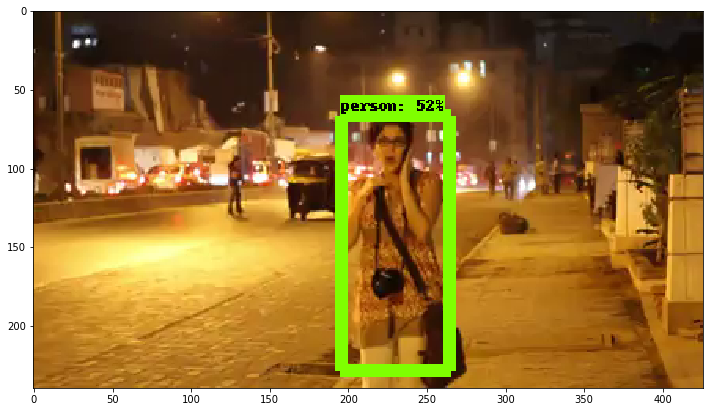

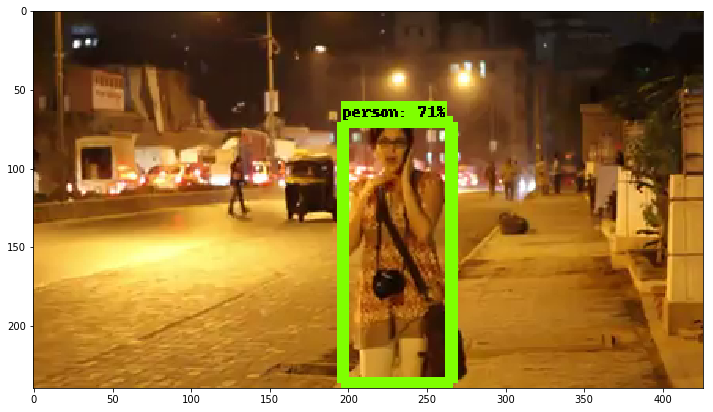

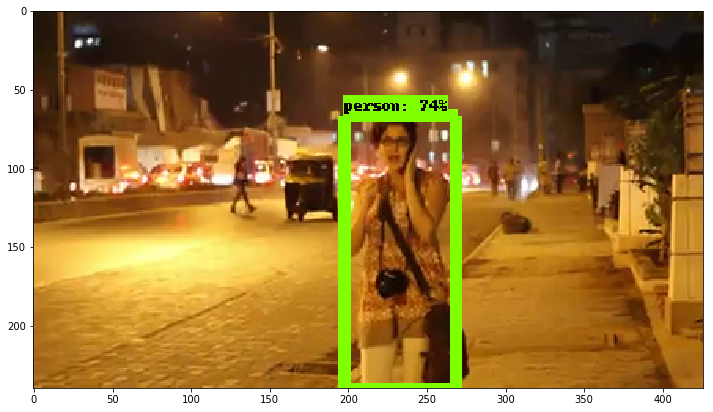

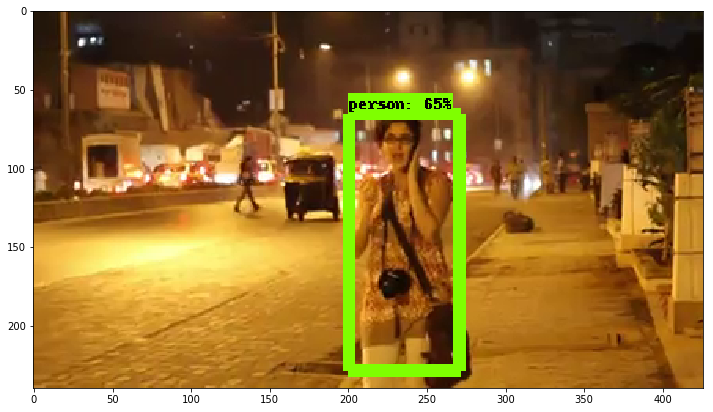

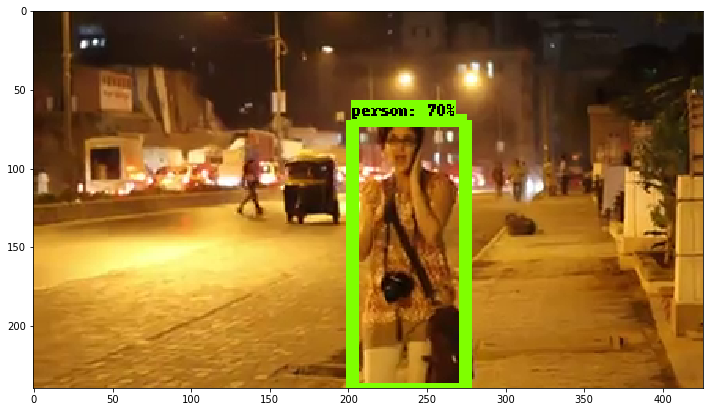

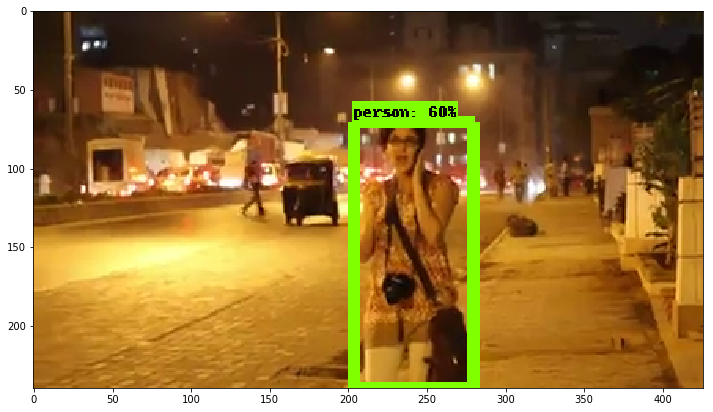

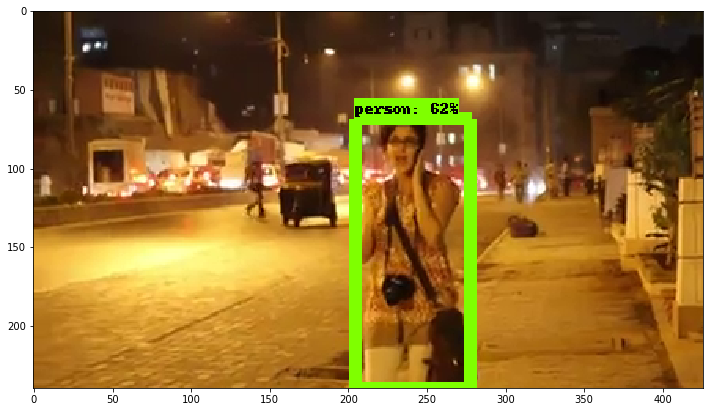

In [ ]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    cap = cv2.VideoCapture('/Users/nikhilkasukurthi/Desktop/240p1.mp4')
    while(cap.isOpened()):
        ret, normal = cap.read()
        # the array based representation of the image will be used later in order to prepare the
        # result image with boxes and labels on it.
        #image_np = load_image_into_numpy_array(frame)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        frame = cv2.cvtColor(normal, cv2.COLOR_BGR2RGB)
        image_np_expanded = np.expand_dims(frame, axis=0)
        # Actual detection.
        (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
        # Visualization of the results of a detection.
        #print(detection_classes)
        vis_util.visualize_boxes_and_labels_on_image_array(
          frame,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
        
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(frame)